In [2]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime, timedelta, time
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from statsmodels.nonparametric.smoothers_lowess import lowess

In [18]:
holl = pd.read_csv("data/HOLLISTR_1_N101_DAM.csv")
holl = holl[holl['LMP_TYPE'] == 'MCE']
holl.drop(columns=holl.columns[holl.nunique() == 1], inplace=True)
holl['INTERVALSTARTTIME_GMT'] = pd.to_datetime(holl['INTERVALENDTIME_GMT'].str.slice(0, 19))
holl.set_index('INTERVALSTARTTIME_GMT', inplace=True)

power = pd.read_csv("data/pv_power.csv", names=["ds", "y"], header=1)
power['ds'] = pd.to_datetime(power['ds'].str.slice(0, 19))
power = power[power['ds'].dt.day < power['ds'].dt.day.max()]



In [20]:
holl.sort_index()

,INTERVALENDTIME_GMT,OPR_DT,OPR_HR,MW,GROUP
INTERVALSTARTTIME_GMT,,,,,
2022-03-20 01:00:00,2022-03-20T01:00:00-00:00,2022-03-19,18,47.24546,3
2022-03-20 02:00:00,2022-03-20T02:00:00-00:00,2022-03-19,19,67.55730,3
2022-03-20 03:00:00,2022-03-20T03:00:00-00:00,2022-03-19,20,82.40015,3
2022-03-20 04:00:00,2022-03-20T04:00:00-00:00,2022-03-19,21,74.57435,3
2022-03-20 05:00:00,2022-03-20T05:00:00-00:00,2022-03-19,22,63.45887,3
...,...,...,...,...,...
2023-03-19 20:00:00,2023-03-19T20:00:00-00:00,2023-03-19,13,40.84036,8
2023-03-19 21:00:00,2023-03-19T21:00:00-00:00,2023-03-19,14,39.08205,8
2023-03-19 22:00:00,2023-03-19T22:00:00-00:00,2023-03-19,15,38.35207,8


In [11]:
holl[holl['LMP_TYPE'] == 'LMP']

,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,OPR_DT,OPR_HR,LMP_TYPE,XML_DATA_ITEM,MW,GROUP
0,2022-03-20T00:00:00-00:00,2022-03-20T01:00:00-00:00,2022-03-19,18,LMP,LMP_PRC,50.11810,1
1,2022-03-20T03:00:00-00:00,2022-03-20T04:00:00-00:00,2022-03-19,21,LMP,LMP_PRC,77.15462,1
2,2022-03-20T02:00:00-00:00,2022-03-20T03:00:00-00:00,2022-03-19,20,LMP,LMP_PRC,84.84744,1
3,2022-03-20T06:00:00-00:00,2022-03-20T07:00:00-00:00,2022-03-19,24,LMP,LMP_PRC,51.64010,1
4,2022-03-20T01:00:00-00:00,2022-03-20T02:00:00-00:00,2022-03-19,19,LMP,LMP_PRC,69.66509,1
...,...,...,...,...,...,...,...,...
43727,2023-03-19T11:00:00-00:00,2023-03-19T12:00:00-00:00,2023-03-19,5,LMP,LMP_PRC,60.81856,6
43728,2023-03-19T19:00:00-00:00,2023-03-19T20:00:00-00:00,2023-03-19,13,LMP,LMP_PRC,65.73788,6
43729,2023-03-19T10:00:00-00:00,2023-03-19T11:00:00-00:00,2023-03-19,4,LMP,LMP_PRC,60.73655,6
43730,2023-03-19T20:00:00-00:00,2023-03-19T21:00:00-00:00,2023-03-19,14,LMP,LMP_PRC,64.04538,6


In [5]:
holl['LMP_TYPE'].unique()

array(['LMP', 'MCC', 'MCE', 'MCL', 'MGHG'], dtype=object)

In [164]:
holl[holl['INTERVALSTARTTIME_GMT'] == '2022-03-20T00:00:00-00:00']

,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,OPR_DT,OPR_HR,LMP_TYPE,XML_DATA_ITEM,MW,OPR_INTERVAL,GROUP
0,2022-03-20T00:00:00-00:00,2022-03-20T00:05:00-00:00,2022-03-19,18,MCC,LMP_CONG_PRC,100.46894,1,1
84,2022-03-20T00:00:00-00:00,2022-03-20T00:05:00-00:00,2022-03-19,18,MCE,LMP_ENE_PRC,42.60554,1,2
168,2022-03-20T00:00:00-00:00,2022-03-20T00:05:00-00:00,2022-03-19,18,MCL,LMP_LOSS_PRC,1.18017,1,3
252,2022-03-20T00:00:00-00:00,2022-03-20T00:05:00-00:00,2022-03-19,18,LMP,LMP_PRC,144.25465,1,4


In [161]:
for c in holl.columns:
    print(holl[c].unique()[:10])

['2022-03-20T00:00:00-00:00' '2022-03-20T00:05:00-00:00'
 '2022-03-20T00:10:00-00:00' '2022-03-20T00:15:00-00:00'
 '2022-03-20T00:20:00-00:00' '2022-03-20T00:25:00-00:00'
 '2022-03-20T00:30:00-00:00' '2022-03-20T00:35:00-00:00'
 '2022-03-20T00:40:00-00:00' '2022-03-20T00:45:00-00:00']
['2022-03-20T00:05:00-00:00' '2022-03-20T00:10:00-00:00'
 '2022-03-20T00:15:00-00:00' '2022-03-20T00:20:00-00:00'
 '2022-03-20T00:25:00-00:00' '2022-03-20T00:30:00-00:00'
 '2022-03-20T00:35:00-00:00' '2022-03-20T00:40:00-00:00'
 '2022-03-20T00:45:00-00:00' '2022-03-20T00:50:00-00:00']
['2022-03-19' '2022-03-20' '2022-03-21' '2022-03-22' '2022-03-23'
 '2022-03-24' '2022-03-25' '2022-03-26' '2022-03-27' '2022-03-28']
[18 19 20 21 22 23 24  1  2  3]
['MCC' 'MCE' 'MCL' 'LMP']
['LMP_CONG_PRC' 'LMP_ENE_PRC' 'LMP_LOSS_PRC' 'LMP_PRC']
[100.46894  92.47924  94.32418 129.84532 126.31642 125.07351 112.17721
 104.49654 106.20034 306.9165 ]
[ 1  2  3  4  5  6  7  8  9 10]
[1 2 3 4 5 6 7 8]


15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing


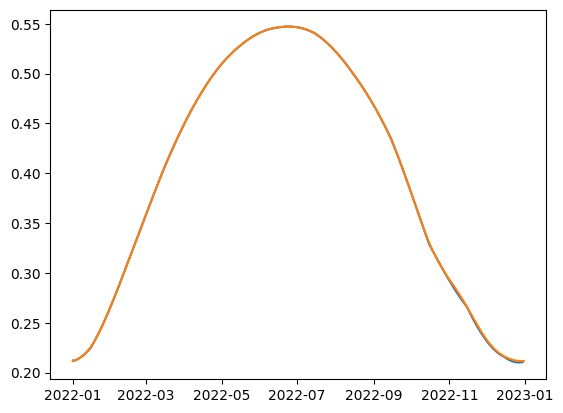

In [3]:
pmd = power.groupby(power['ds'].dt.date)[['y']].mean().reset_index()
pmd['ds'] = pd.to_datetime(pmd['ds'])
pmd_smooth = lowess(pmd['y'], pmd['ds'].dt.day_of_year.to_numpy(), frac=0.03)[:,1]
diff = np.abs(pmd_smooth - pmd['y'])
pmd['y'] = np.where(diff < 0.01, pmd['y'], pmd_smooth)

model = Prophet(yearly_seasonality=True, growth='flat')
model.fit(pmd.iloc[:-60])
future = pd.DataFrame(data=pd.date_range(start=datetime(2022, 1, 1), periods=365, freq='D'), columns=['ds'])
pred_day = model.predict(future)['yhat'].to_numpy()
plt.plot(pmd['ds'], pmd['y'])
plt.plot(future['ds'], pred_day)
plt.show()

In [28]:
day_avg = power.groupby(power['ds'].dt.date)['y'].mean()
power['yday_avg'] = day_avg.loc[power['ds'].dt.date].to_numpy()
power['y_relative'] = power['y'] / power['yday_avg']
avg_day = power.groupby(power['ds'].dt.hour*60 + power['ds'].dt.minute)\
                            ['y_relative'].mean().to_numpy()
y = (avg_day[None,:] * day_avg.to_numpy()[:,None]).flatten()

# days = future['ds'].to_numpy()[:,None] 
days = power['ds'].dt.date.unique()
days = np.array([datetime.combine(d, time()) for d in days])[:,None]
minutes = np.array([timedelta(minutes=m) for m in range(0, 1440, 5)])[None,:]
t = (days + minutes).flatten()

pred = pd.DataFrame({'ds' : t, 'y' : y})

In [35]:
power['date'] = power['ds'].dt.date

In [37]:
power.set_index('date', inplace=True)

In [155]:
day0 = power.loc[power.index[300]]
day0y = day0['y_relative'].to_numpy()
day0x = ((day0['ds'].dt.hour*60 + day0['ds'].dt.minute)//5).to_numpy()
day0 = interp1d(day0x, day0y, fill_value='extrapolate')

def day_diff(x, y, shift, scale):
    return ((day0((day0x-shift)*scale)*scale - y)**2).mean()

def get_pars(y):
    return minimize(lambda arg: day_diff(x, y, *arg), x0=(0,1), bounds=[(-100, 100), (0.5, 2)])

days = power.index.unique()
day1 = power.loc[days[0]]
day1x = ((day1['ds'].dt.hour*60 + day1['ds'].dt.minute)//5).to_numpy()
day1y = day1['y_relative'].to_numpy()
arr = np.a()
# get_pars(day1x, day1y)

In [156]:
df

,x,y,x1
0,1,0.0,0
1,2,0.0,1
2,3,0.0,2
3,4,0.0,3
4,5,0.0,4
...,...,...,...
282,283,0.0,282
283,284,0.0,283
284,285,0.0,284
285,286,0.0,285


In [133]:
day_diff(day1x, day1y, 2.515e+01,  9.271e-01)

0.5176535081310252

In [144]:
day1x

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [134]:
day_diff(day1x, day1y, -73,  0.64)

3.243639113676622

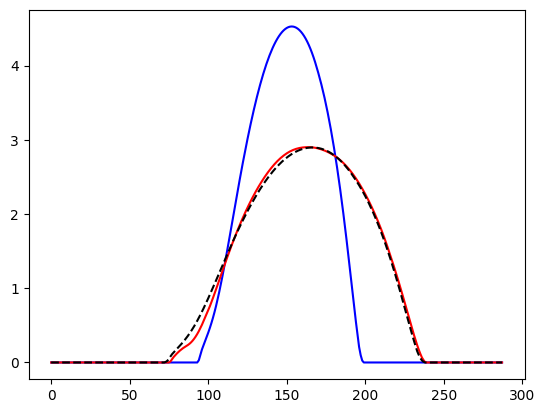

In [131]:
plt.plot(power.loc[power.index[300]]['y_relative'].to_numpy(), 'b')
plt.plot(day1x, day1y, 'r')
r[0] = -73
r[1] = 0.64
plt.plot(day1x, day0((day1x-r[0])*r[1])*r[1], '--k')
plt.show()

In [49]:
for i, d in enumerate(power.index.unique()):
    df = power.loc[d]
    y = df['y_relative']
    x = df['ds'].dt.hour * 60 + df['ds'].dt.minute
    plt.plot(x, y)
    plt.savefig(f'./anim/{i}.png')
    plt.clf()

<Figure size 640x480 with 0 Axes>

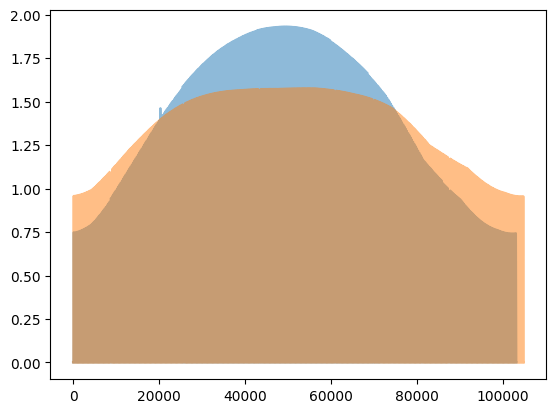

In [33]:
plt.plot(pred['y'], alpha=0.5)
plt.plot(power['y'], alpha=0.5)

In [23]:
days[0,0] + timedelta(minutes=10)

datetime.date(2022, 1, 1)

In [13]:
power

,ds,y,yday_avg,y_relative
0,2022-01-01 00:05:00,0.0,0.212075,0.0
1,2022-01-01 00:10:00,0.0,0.212075,0.0
2,2022-01-01 00:15:00,0.0,0.212075,0.0
3,2022-01-01 00:20:00,0.0,0.212075,0.0
4,2022-01-01 00:25:00,0.0,0.212075,0.0
...,...,...,...,...
104826,2022-12-30 23:35:00,0.0,0.210480,0.0
104827,2022-12-30 23:40:00,0.0,0.210480,0.0
104828,2022-12-30 23:45:00,0.0,0.210480,0.0
104829,2022-12-30 23:50:00,0.0,0.210480,0.0


In [212]:
ppd_all.index.to_series().apply(lambda m: timedelta(minutes=m)).to_numpy()[0]

numpy.timedelta64(0,'ns')

In [209]:
datetime(2022, 1, 1) + timedelta(minutes=5)

datetime.datetime(2022, 1, 1, 0, 5)

In [208]:
days[0,0] + minutes[0]

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('O') and dtype('<m8[ns]')

In [202]:
y.shape, t.shape

((103104,), (29690208,))

In [187]:
diff = pred.set_index('ds') - power.set_index('ds')

In [ ]:
plt.plot(avg_day);

In [ ]:
plt.hist(diff.abs(), density=True, bins=10)
plt.show()

In [ ]:
plt.plot(pred['ds'], pred['y'], alpha=0.5)
plt.plot(power['ds'], power['y'], alpha=0.5)
plt.show()